In [140]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_json('movie_data.json')

In [4]:
df['views_coeff'] = 1 - 1/df['views']

In [4]:
df['likes_coeff'] = df['likes']/df['views']
df['dis_coeff'] = df['dislikes']/df['views']
df['dis_likes'] = 1 / (df['likes'] / df['dislikes'])

In [ ]:
df.loc[df[df['views_coeff'] < 0].index, 'views_coeff'] = 0

In [77]:
df.loc[df[df['likes_coeff'] < 0].index, 'likes_coeff'] = df.loc[df[df['likes_coeff'] < 0].index, 'likes_coeff'].abs()

In [62]:
df.loc[df[df['likes_coeff'] == np.inf].index, 'likes_coeff'] = 0

In [92]:
df['rating'] = (1 + df['likes_coeff'] - df['dis_coeff'])

In [110]:
df['views_scaled'] = (df['views_coeff'] - df['views_coeff'].min()) / (df['views_coeff'].max() - df['views_coeff'].min())

In [111]:
df['views_coeff'].describe()

count    71717.000000
mean         0.830185
std          0.345259
min          0.000000
25%          0.933333
50%          0.997396
75%          0.999883
max          1.000000
Name: views_coeff, dtype: float64

In [106]:
df.loc[df[df['views_coeff'] < 0].index, 'views_coeff'] = 0

##### Let's go

In [5]:
df['views_coeff'].describe()

count    7.171700e+04
mean             -inf
std               NaN
min              -inf
25%      9.333333e-01
50%      9.973958e-01
75%      9.998834e-01
max      9.999999e-01
Name: views_coeff, dtype: float64

##### clean of infinities

In [6]:
df.loc[df[df['views_coeff'] == np.NINF].index, 'views_coeff'] = 0

In [7]:
from sklearn.preprocessing import RobustScaler, QuantileTransformer, MinMaxScaler

In [8]:
scaler = RobustScaler()

In [9]:
scaler.fit_transform(np.reshape(df['views_coeff'].array, (-1,1)))

array([[  0.03884854],
       [  0.03904412],
       [  0.03906133],
       ...,
       [-14.98713879],
       [-14.98713879],
       [-14.98713879]])

In [10]:
%%timeit
scaled = pd.DataFrame(scaler.fit_transform(np.reshape(df['views_coeff'].array, (-1,1))))

2.17 ms ± 12.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
scaled = pd.DataFrame(scaler.fit_transform(np.reshape(df['views_coeff'].array, (-1,1))))

In [15]:
scaled[0] = scaled[0] - np.floor(scaled[0].min())

##### likes / views

In [17]:
df['likes_coeff'] = df['likes'] / df['views']

In [18]:
df.loc[df[df['likes_coeff'] > 1].index, 'likes_coeff'] = 1

In [19]:
df.loc[df[df['likes_coeff'] < 0].index, 'likes_coeff'] = 0

In [20]:
df.loc[df[df['likes_coeff'].isna() == True].index, 'likes_coeff'] = 0

In [21]:
scaled = pd.concat([scaled,
           pd.DataFrame(QuantileTransformer().fit_transform(np.reshape(df['likes_coeff'].array, (-1,1))))
          ], axis=1
         )

scaled.drop('likes', axis=1, inplace=True)

In [22]:
scaled.columns = ('views', 'likes')

In [25]:
scaled['likes'] = scaled['likes'] + 2

##### dislikes / views

In [27]:
df['dislikes_coeff'] = 1 - df['dislikes'] / df['views']

In [28]:
df.loc[df[df['dislikes_coeff'].isna() == True].index, 'dislikes_coeff'] = 0

In [29]:
scaler = QuantileTransformer()

In [30]:
scaled = pd.concat([scaled,
           pd.DataFrame(scaler.fit_transform(np.reshape(df['dislikes_coeff'].array, (-1,1))))
          ], axis=1
         )

scaled.drop(scaled.columns[2:], axis=1, inplace=True)

In [31]:
scaled.columns = ('views', 'likes', 'dislikes')

In [33]:
scaled.describe()

,views,likes,dislikes
count,71717.000000,71717.000000,71717.000000
mean,12.487446,2.270823,0.678686
std,5.187954,0.395671,0.408791
min,0.012861,2.000000,0.000000
25%,14.037380,2.000000,0.249976
50%,15.000000,2.000000,1.000000
75%,15.037380,2.749983,1.000000
max,15.039129,3.000000,1.000000


In [34]:
scaled['dislikes'] = scaled['dislikes'] + 2

##### likes / dislikes

In [35]:
df['l_d_coeff'] = df['likes']/df['dislikes']

In [45]:
locate = df[df['l_d_coeff'] == np.inf].index

In [48]:
df.loc[locate, 'l_d_coeff'] = df.loc[locate, 'likes'] 

In [51]:
df[df['l_d_coeff'].isna() == True]

,id,likes,dislikes,views,days_ago,views_coeff,likes_coeff,dislikes_coeff,l_d_coeff
4058,5011,0,0,1097,495.0,0.999088,0.0,1.0,NaN
5587,6926,0,0,982,678.0,0.998982,0.0,1.0,NaN
8760,10862,0,0,0,NaN,0.000000,0.0,0.0,NaN
8761,10863,0,0,0,NaN,0.000000,0.0,0.0,NaN
8762,10864,0,0,0,NaN,0.000000,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...
71712,85651,0,0,0,NaN,0.000000,0.0,0.0,NaN
71713,85652,0,0,0,NaN,0.000000,0.0,0.0,NaN
71714,85653,0,0,0,NaN,0.000000,0.0,0.0,NaN
71715,85654,0,0,0,NaN,0.000000,0.0,0.0,NaN


In [52]:
df.loc[df[df['l_d_coeff'].isna() == True].index, 'l_d_coeff'] = 1

In [53]:
df.loc[df[df['l_d_coeff'] < 0].index, 'l_d_coeff'] = 1

In [54]:
scaler = QuantileTransformer(output_distribution='normal')

In [55]:
scaled = pd.concat([scaled,
           pd.DataFrame(scaler.fit_transform(np.reshape(df['l_d_coeff'].array, (-1,1))))
          ], axis=1
         )

In [56]:
scaled.describe()

,views,likes,dislikes,0
count,71717.000000,71717.000000,71717.000000,71717.000000
mean,12.487446,2.270823,2.678686,-0.010579
std,5.187954,0.395671,0.408791,0.967885
min,0.012861,2.000000,2.000000,-5.199338
25%,14.037380,2.000000,2.249976,-0.062770
50%,15.000000,2.000000,3.000000,-0.062770
75%,15.037380,2.749983,3.000000,-0.062770
max,15.039129,3.000000,3.000000,5.199338


In [57]:
scaled[0].max()

5.19933758270342

In [58]:
scaled[0].min()

-5.199337582605575

In [59]:
scaled[0] += abs(scaled[0].min())

In [60]:
scaled[0] /= scaled[0].max()

In [61]:
scaled[0] += 0.5

In [62]:
scaled.columns = list(scaled.columns[:-1]) + ['l_d']

##### time coeff

In [67]:
df['time_coeff'] = np.log(1/df['days_ago'])*(df['days_ago']/365)**1.1

In [68]:
df.loc[df['time_coeff'].isna() == True, 'time_coeff'] = 0

In [69]:
scaler = MinMaxScaler()

In [70]:
scaled = pd.concat([scaled,
           pd.DataFrame(scaler.fit_transform(np.reshape(df['time_coeff'].array, (-1,1))))
          ], axis=1
         )

In [71]:
scaled.columns = list(scaled.columns[:-1]) + ['time']

In [72]:
scaled

,views,likes,dislikes,l_d,time
0,15.038849,2.959848,2.246043,1.167523,0.057341
1,15.039044,2.771618,2.261472,0.874527,0.090318
2,15.039061,2.905548,2.366014,1.169229,0.106279
3,15.038462,2.962223,2.227097,1.168479,0.113791
4,15.038987,2.936345,2.210343,1.137203,0.114391
...,...,...,...,...,...
71712,0.012861,2.000000,2.000000,0.993964,1.000000
71713,0.012861,2.000000,2.000000,0.993964,1.000000
71714,0.012861,2.000000,2.000000,0.993964,1.000000
71715,0.012861,2.000000,2.000000,0.993964,1.000000


In [73]:
rating = pd.Series(index=df.index, name='rating', dtype='float64', data=1)

In [74]:
rating

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
71712    1.0
71713    1.0
71714    1.0
71715    1.0
71716    1.0
Name: rating, Length: 71717, dtype: float64

In [75]:
for index, name in enumerate(scaled.columns):
    rating *= scaled[name]

In [76]:
rating.describe()

count    71717.000000
mean        68.894186
std         34.376783
min          0.000000
25%         55.767849
50%         82.616434
75%         86.525354
max        183.123420
Name: rating, dtype: float64

In [80]:
df.loc[rating[rating > 9].index, :]

,id,likes,dislikes,views,days_ago,views_coeff,likes_coeff,dislikes_coeff,l_d_coeff,time_coeff
2,13,1546,391,215958,3632.0,0.999995,0.007159,0.998189,3.953964,-102.641207
3,14,413,109,22462,3607.0,0.999955,0.018387,0.995147,3.788991,-101.778490
4,15,980,541,104406,3605.0,0.999990,0.009386,0.994818,1.811460,-101.709527
5,16,500,238,64613,3602.0,0.999985,0.007738,0.996317,2.100840,-101.606097
6,17,1770,571,164843,3590.0,0.999994,0.010737,0.996536,3.099825,-101.192558
...,...,...,...,...,...,...,...,...,...,...
71692,85631,0,0,16,1.0,0.937500,0.000000,1.000000,1.000000,0.000000
71702,85641,0,0,78,0.0,0.987179,0.000000,1.000000,1.000000,0.000000
71703,85642,0,0,2,0.0,0.500000,0.000000,1.000000,1.000000,0.000000
71704,85643,2,0,130,0.0,0.992308,0.015385,1.000000,2.000000,0.000000


In [328]:
df[:10]

,id,likes,dislikes,views,days_ago,views_coeff,likes_coeff,dislikes_coeff,l_d_coeff,time_coeff
0,5.0,861.0,241.0,53214.0,3794.0,0.999981,0.016180,0.995471,3.572614,-108.261516
1,9.0,630.0,740.0,173130.0,3685.0,0.999994,0.003639,0.995726,0.851351,-104.474282
2,13.0,1546.0,391.0,215958.0,3632.0,0.999995,0.007159,0.998189,3.953964,-102.641207
3,14.0,413.0,109.0,22462.0,3607.0,0.999955,0.018387,0.995147,3.788991,-101.778490
4,15.0,980.0,541.0,104406.0,3605.0,0.999990,0.009386,0.994818,1.811460,-101.709527
5,16.0,500.0,238.0,64613.0,3602.0,0.999985,0.007738,0.996317,2.100840,-101.606097
6,17.0,1770.0,571.0,164843.0,3590.0,0.999994,0.010737,0.996536,3.099825,-101.192558
7,4994.0,4994.0,4994.0,4994.0,4994.0,4994.000000,4994.000000,4994.000000,1.000000,-151.358394
8,20.0,9020.0,8309.0,1244101.0,3580.0,0.999999,0.007250,0.993321,1.085570,-100.848164
9,24.0,1307.0,687.0,160829.0,3568.0,0.999994,0.008127,0.995728,1.902475,-100.435158


In [329]:
45/2239

0.02009825815096025

In [84]:
pd.concat([df,rating], axis=1)

,id,likes,dislikes,views,days_ago,views_coeff,likes_coeff,dislikes_coeff,l_d_coeff,time_coeff,rating
0,5,861,241,53214,3794.0,0.999981,0.016180,0.995471,3.572614,-108.261516,6.693224
1,9,630,740,173130,3685.0,0.999994,0.003639,0.995726,0.851351,-104.474282,7.445451
2,13,1546,391,215958,3632.0,0.999995,0.007159,0.998189,3.953964,-102.641207,12.847293
3,14,413,109,22462,3607.0,0.999955,0.018387,0.995147,3.788991,-101.778490,13.191296
4,15,980,541,104406,3605.0,0.999990,0.009386,0.994818,1.811460,-101.709527,12.697424
...,...,...,...,...,...,...,...,...,...,...,...
71712,85651,0,0,0,NaN,0.000000,0.000000,0.000000,1.000000,0.000000,0.051134
71713,85652,0,0,0,NaN,0.000000,0.000000,0.000000,1.000000,0.000000,0.051134
71714,85653,0,0,0,NaN,0.000000,0.000000,0.000000,1.000000,0.000000,0.051134
71715,85654,0,0,0,NaN,0.000000,0.000000,0.000000,1.000000,0.000000,0.051134


In [96]:
prep = pd.concat([df[['id', 'views', 'likes', 'dislikes', 'days_ago']],rating], axis=1)

In [131]:
scaled.describe()

,views,likes,dislikes,l_d,time
count,71717.000000,71717.000000,71717.000000,71717.000000,71717.000000
mean,12.487446,2.270823,2.678686,0.998983,0.892857
std,5.187954,0.395671,0.408791,0.093078,0.147457
min,0.012861,2.000000,2.000000,0.500000,0.000000
25%,14.037380,2.000000,2.249976,0.993964,0.892368
50%,15.000000,2.000000,3.000000,0.993964,0.948628
75%,15.037380,2.749983,3.000000,0.993964,0.968942
max,15.039129,3.000000,3.000000,1.500000,1.000000


In [132]:
scaled

,views,likes,dislikes,l_d,time
0,15.038849,2.959848,2.246043,1.167523,0.057341
1,15.039044,2.771618,2.261472,0.874527,0.090318
2,15.039061,2.905548,2.366014,1.169229,0.106279
3,15.038462,2.962223,2.227097,1.168479,0.113791
4,15.038987,2.936345,2.210343,1.137203,0.114391
...,...,...,...,...,...
71712,0.012861,2.000000,2.000000,0.993964,1.000000
71713,0.012861,2.000000,2.000000,0.993964,1.000000
71714,0.012861,2.000000,2.000000,0.993964,1.000000
71715,0.012861,2.000000,2.000000,0.993964,1.000000


In [133]:
prep.sort_values('rating')

,id,views,likes,dislikes,days_ago,rating
39994,48016,54369,222,302,3982.0,0.000000
6459,8016,59206,222,302,3982.0,0.000000
44285,52853,1,0,1,454.0,0.023980
8771,10874,0,0,0,462.0,0.047594
8774,10877,0,0,0,461.0,0.047604
...,...,...,...,...,...,...
13313,15419,17183,4974,0,503.0,167.585430
46848,55419,17680,4980,0,503.0,168.617160
13218,15324,10505,4987,0,497.0,170.866483
13611,15717,17842,4995,0,599.0,183.123420


In [100]:
prep.describe()

,id,views,likes,dislikes,days_ago,rating
count,71717.000000,7.171700e+04,71717.000000,71717.000000,67325.000000,71717.000000
mean,42280.861386,1.510061e+04,162.601643,73.929835,626.380973,68.894186
std,24553.015801,8.510321e+04,811.661896,541.016825,646.002122,34.376783
min,5.000000,0.000000e+00,-2.000000,0.000000,0.000000,0.000000
25%,20899.000000,1.500000e+01,0.000000,0.000000,248.000000,55.767849
50%,43128.000000,3.840000e+02,0.000000,0.000000,393.000000,82.616434
75%,63283.000000,8.580000e+03,25.000000,5.000000,693.000000,86.525354
max,85655.000000,7.667140e+06,56745.000000,41492.000000,3982.000000,183.123420


In [134]:
prep.corr()

,id,views,likes,dislikes,days_ago,rating
id,1.000000,-0.122089,-0.103793,-0.105088,-0.408994,0.070681
views,-0.122089,1.000000,0.738835,0.954673,0.321767,-0.041985
likes,-0.103793,0.738835,1.000000,0.717358,0.217183,0.200640
dislikes,-0.105088,0.954673,0.717358,1.000000,0.290389,-0.068130
days_ago,-0.408994,0.321767,0.217183,0.290389,1.000000,-0.296962
rating,0.070681,-0.041985,0.200640,-0.068130,-0.296962,1.000000


In [135]:
import seaborn as sns

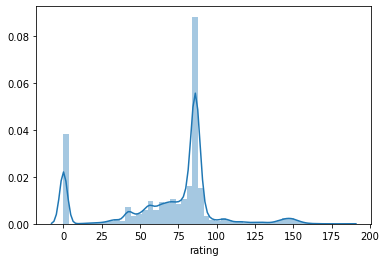

In [125]:
sns.distplot(prep['rating'])

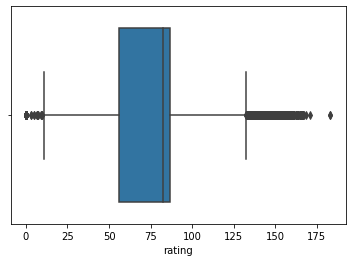

In [106]:
sns.boxplot(prep['rating'])

In [121]:
prep.set_index('id').loc[:, 'rating'].to_json('movie_ratings.json')